## Import the necessary dependencies

In [38]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import torch

## Load the Yelp review dataset in JSON format into a Dataframe

In [39]:
# Function to get the total number of lines in the file
def get_total_lines(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        return sum(1 for _ in file)

# Function to load rows where 'stars' feature is 1.0 or 2.0
def load_selected_data_0(filename):
    data = []
    count = 0
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            row = json.loads(line)
            if row.get('stars') in [1.0, 2.0]:  # Check for 1.0 or 2.0 stars
                data.append(row)
                count += 1
                if count == 10000:  # Stop after collecting 10000 rows
                    break
    return data

# Function to load rows where 'stars' feature is 3.0
def load_selected_data_1(filename):
    data = []
    count = 0
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            row = json.loads(line)
            if row.get('stars') == 3.0:
                data.append(row)
                count += 1
                if count == 10000:  # Stop after collecting 10000 rows
                    break
    return data

# Function to load rows where 'stars' feature is 4.0 or 5.0
def load_selected_data_2(filename):
    data = []
    count = 0
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            row = json.loads(line)
            if row.get('stars') in [4.0, 5.0]:  # Check for 4.0 or 5.0 stars
                data.append(row)
                count += 1
                if count == 10000:  # Stop after collecting 10000 rows
                    break
    return data

# File path
file_path = 'yelp_dataset/yelp_academic_dataset_review.json'

# Load the data
yelp_data_0 = pd.DataFrame(load_selected_data_0(file_path))
yelp_data_1 = pd.DataFrame(load_selected_data_1(file_path))
yelp_data_2 = pd.DataFrame(load_selected_data_2(file_path))

In [40]:
yelp_data_0.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31
1,elqRpX9T3YwL07uLNtN3Bg,-sryo4gDYxbZ1T5Bz4l5Bw,ltBBYdNzkeKdCNPDAsxwAA,2.0,0,0,0,I at least have to give this restaurant two st...,2015-02-02 04:29:13
2,RB8UpF_kT2xoOC51OzXEeA,EZjT2qJN0mOXypMAqZdSrQ,A2q7d-CBM2-81tVkmS4JMw,2.0,1,1,0,"Straight to the point, it's cheap, it tastes a...",2017-07-08 18:58:42
3,Ki90-hauSIfW_7sBuBBqfA,Z2cOL3n9V8NoguJ-uU_Nvw,j8JOZvfeHEfUWq3gEz6ABQ,2.0,2,3,0,NEVER AGAIN. This is a so called restaurant th...,2014-06-11 14:55:14
4,TcCcHzc3L6Aboq3DteEfZA,OuatwND396ZQxm2zK8WlUQ,jNL5KUPz2-tHUJM__ysSaw,1.0,1,0,0,If you want to pay for everything a la carte t...,2014-08-24 20:14:12


In [41]:
yelp_data_1.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
2,ZKvDG2sBvHVdF5oBNUOpAQ,wSTuiTk-sKNdcFyprzZAjg,B5XSoSG3SfvQGtKEGQ1tSQ,3.0,1,1,0,This easter instead of going to Lopez Lake we ...,2016-03-30 22:46:33
3,pUycOfUwM8vqX7KjRRhUEA,59MxRhNVhU9MYndMkz0wtw,gebiRewfieSdtt17PTW6Zg,3.0,0,0,0,Had a party of 6 here for hibachi. Our waitres...,2016-07-25 07:31:06
4,ZVvhc3Go7v5I8XTiVoWmqQ,WBpQDAZymU0dhIqXcACGNw,ut6fi2W2YaipNOqvi7e0jw,3.0,0,0,0,"Upland is a brewery based out of Bloomington, ...",2014-11-12 14:12:20


In [42]:
yelp_data_2.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
1,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
2,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
3,6AxgBCNX_PNTOxmbRSwcKQ,r3zeYsv1XFBRA4dJpL78cw,gmjsEdUsKpj9Xxu6pdjH0g,5.0,0,2,0,Loved this tour! I grabbed a groupon and the p...,2015-01-03 23:21:18
4,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5.0,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16


### Merging the three DataFrames into one

In [43]:
yelp_data = pd.concat([yelp_data_0, yelp_data_1, yelp_data_2])

# Resetting the index of the combined DataFrame
yelp_data.reset_index(drop=True, inplace=True)

# Shuffle the combined DataFrame
yelp_data = yelp_data.sample(frac=1).reset_index(drop=True)

# Display the first few rows of the shuffled DataFrame
yelp_data.head()


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,GH2ROpfgMj-GwqzKPMM6eg,xCJisO0jOB94krpxoqiuzw,A0F-h3xJm_6gHDKcDQwSrQ,4.0,0,0,0,The best way I can summarize Capogiro is that ...,2013-10-24 20:02:09
1,_1QaaAnPQvYijZZjNCyaSg,qAOBqQY-zlXljpnx0TBSrA,sdFJSq-EgmtplIwUamRwTQ,1.0,0,0,0,"I shouldn't even give one star , waited to be ...",2016-10-30 15:19:26
2,GM6zsjpNV3vOi3LGHsj0gg,X19fJf206WsA0K-UFmXaRg,d_tRshM-w6S4QxE4VVi8tQ,3.0,0,0,1,Went with a friend for a drink and sat at the ...,2011-12-04 15:52:24
3,KMvLIQ-y7gvJCzvbqdY2Jw,Yd8MendthkqRHc-XzNcZYA,VBWUdluhRQf5kqawykM6Nw,3.0,0,0,0,Now I know why there is a line next door at Ne...,2018-07-08 17:40:44
4,CS-mRcCsaB-fXGAcEyxf2Q,WkirJTK8BwCXDQAyARQWZw,UP_qAGs0AJCpD7IH_yI_Eg,5.0,2,0,0,Okay maybe the word awesome is overused but th...,2016-10-26 18:17:50


In [44]:
# Printing the shape
print("DataFrame Shape:", yelp_data.shape)

DataFrame Shape: (30000, 9)


### Check for missing values and duplicated

In [45]:
# Check for duplicates
duplicates = yelp_data.duplicated()
print("Total duplicate rows:", duplicates.sum())

# Check for missing values
missing_values = yelp_data.isnull().sum()
print('\n',missing_values)

Total duplicate rows: 0

 review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64


## Selecting the features

In [46]:
# Select the necessary features
yelp_data = yelp_data[['text', 'stars']]

# Map star ratings to sentiment labels (e.g., 0 for 1-2 stars, 1 for 3 stars, 2 for 4-5 stars)
yelp_data['sentiment'] = yelp_data['stars'].apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))

In [47]:
yelp_data.head()

,text,stars,sentiment
0,The best way I can summarize Capogiro is that ...,4.0,2
1,"I shouldn't even give one star , waited to be ...",1.0,0
2,Went with a friend for a drink and sat at the ...,3.0,1
3,Now I know why there is a line next door at Ne...,3.0,1
4,Okay maybe the word awesome is overused but th...,5.0,2


In [48]:
# Printing the shape
print("DataFrame Shape:", yelp_data.shape)

DataFrame Shape: (30000, 3)


## Splitting the dataset

In [49]:
# Split data into train, validation, and test sets
train_data, test_data = train_test_split(yelp_data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

## Load the pre-trained BERT model

In [50]:
# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# # Define a new configuration with reduced complexity
# reduced_config = BertConfig.from_pretrained('bert-base-uncased', num_labels=3, num_hidden_layers=6, hidden_size=768)
# # Load the model with the reduced configuration
# model = BertForSequenceClassification(reduced_config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Add dropout layers to the model

In [51]:
dropout_prob = 0.15  # You can adjust the dropout probability
model.dropout = torch.nn.Dropout(dropout_prob)

## Tokenize and preprocess the data

In [52]:
def tokenize_data(yelp_data, max_length=128):
    input_ids = []
    attention_masks = []
    labels = []

    for index, row in yelp_data.iterrows():
        review = row['text']
        label = row['sentiment']

        try:
            encoded_data = tokenizer.encode_plus(
                review,
                add_special_tokens=True,
                max_length=max_length,
                padding='max_length',
                return_attention_mask=True,
                return_tensors='pt',
                truncation=True
            )

            input_ids.append(encoded_data['input_ids'])
            attention_masks.append(encoded_data['attention_mask'])
            labels.append(label)
        except Exception as e:
            # Handle tokenization errors (e.g., if a text is too long)
            print(f"Error tokenizing the following text: {review}")
            print(f"Error details: {e}")

    if not input_ids or not attention_masks or not labels:
        raise ValueError("No valid data after tokenization. Check your input.")

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

# Usage
train_input_ids, train_attention_masks, train_labels = tokenize_data(train_data)
val_input_ids, val_attention_masks, val_labels = tokenize_data(val_data)
test_input_ids, test_attention_masks, test_labels = tokenize_data(test_data)


## Define dataloaders

In [53]:
batch_size = 32

train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)

test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

In [54]:
# Check if M1 GPU is available; if not, use CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Move the model to the appropriate device
model.to(device)

Using device: mps


/Users/pubudusenarathne/Library/Python/3.9/lib/python/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Training loop

In [55]:
# num_epochs = 3

# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0

#     for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}'):
#         batch = tuple(t.to(device) for t in batch)
#         input_ids, attention_mask, labels = batch

#         optimizer.zero_grad()

#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs.loss
#         total_loss += loss.item()

#         loss.backward()
#         optimizer.step()

#     average_loss = total_loss / len(train_dataloader)
#     print(f'Average Loss: {average_loss:.4f}')

In [56]:
# train_losses = []
# val_losses = []
# train_accuracies = []
# val_accuracies = []

# num_epochs = 4

# # Early stopping parameters
# early_stopping_patience = 3  # Number of epochs to wait after last time validation loss improved.
# best_val_loss = float('inf')  # Initialize the best validation loss as infinity.
# early_stopping_counter = 0    # Counter for how many epochs without improvement.


# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0
#     correct = 0
#     total = 0

#     for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}'):
#         batch = tuple(t.to(device) for t in batch)
#         input_ids, attention_mask, labels = batch

#         optimizer.zero_grad()

#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs.loss
#         total_loss += loss.item()

#         loss.backward()
#         optimizer.step()

#         _, predicted = torch.max(outputs.logits, 1)
#         correct += (predicted == labels).sum().item()
#         total += labels.size(0)

#     average_loss = total_loss / len(train_dataloader)
#     train_accuracy = correct / total

#     train_losses.append(average_loss)
#     train_accuracies.append(train_accuracy)

#     # Validation
#     model.eval()
#     val_loss = 0
#     val_correct = 0
#     val_total = 0

#     for batch in tqdm(val_dataloader, desc='Validation'):
#         batch = tuple(t.to(device) for t in batch)
#         input_ids, attention_mask, labels = batch

#         with torch.no_grad():
#             outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#             if isinstance(outputs, tuple):
#                 loss = outputs[0]
#             elif isinstance(outputs, dict):
#                 loss = outputs['loss']
#             else:
#                 raise ValueError("Loss not found in model outputs.")
#             val_loss += loss.item()

#             _, predicted = torch.max(outputs.logits, 1)
#             val_correct += (predicted == labels).sum().item()
#             val_total += labels.size(0)

#     val_average_loss = val_loss / len(val_dataloader)
#     val_accuracy = val_correct / val_total

#     val_losses.append(val_average_loss)
#     val_accuracies.append(val_accuracy)

#     print(f'Epoch {epoch + 1} - Train Loss: {average_loss:.4f} - Val Loss: {val_average_loss:.4f} - Train Acc: {train_accuracy:.4f} - Val Acc: {val_accuracy:.4f}')

#     # Early stopping check
#     if val_average_loss < best_val_loss:
#         best_val_loss = val_average_loss
#         early_stopping_counter = 0
#     else:
#         early_stopping_counter += 1
#         if early_stopping_counter >= early_stopping_patience:
#             print(f'Early stopping triggered. Stopping at epoch {epoch + 1}.')
#             break

## Saving the model

In [57]:
# torch.save(model, 'bert_model.pth')

## Loading the saved model

In [58]:
model = torch.load('bert_model.pth')
model.to(device) 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Evaluation

### Classification report

In [ ]:
model.eval()
predictions = []
true_labels = []

for batch in tqdm(val_dataloader, desc='Validation'):
    batch = tuple(t.to(device) for t in batch)
    input_ids, attention_mask, labels = batch

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    predicted_labels = torch.argmax(logits, dim=1).tolist()
    predictions.extend(predicted_labels)
    true_labels.extend(labels.tolist())

accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions)

print(f'Validation Accuracy: {accuracy:.4f}')
print(report)

Validation: 100%|██████████| 94/94 [00:21<00:00,  4.30it/s]

Validation Accuracy: 0.7850
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       978
           1       0.71      0.65      0.68      1008
           2       0.84      0.86      0.85      1014

    accuracy                           0.79      3000
   macro avg       0.78      0.79      0.78      3000
weighted avg       0.78      0.79      0.78      3000



### Confusion matrix

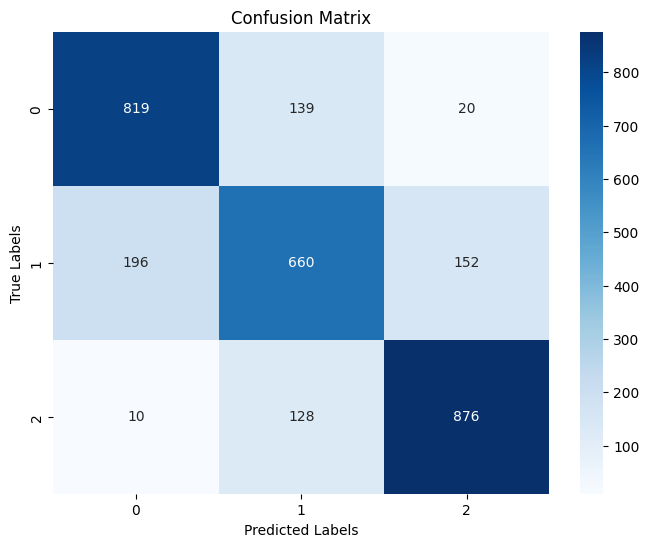

In [ ]:
# Create a confusion matrix
confusion_mat = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Bar chart

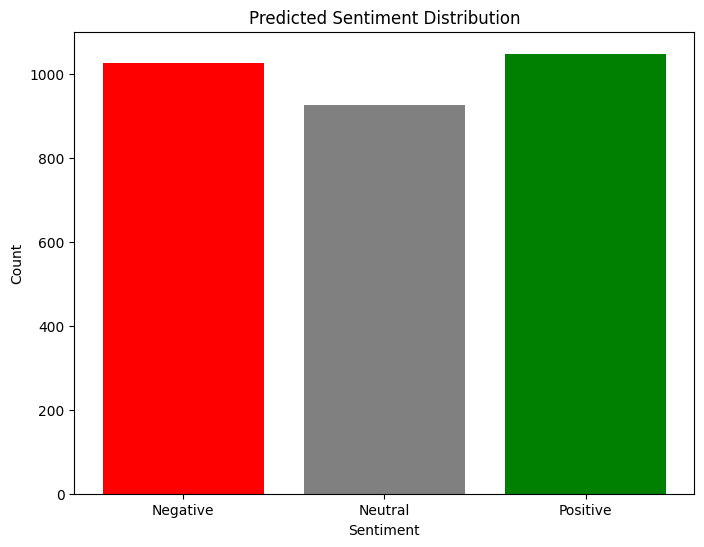

In [ ]:
# Count the predicted sentiment labels
predicted_counts = [predictions.count(0), predictions.count(1), predictions.count(2)]

# Define sentiment labels
sentiment_labels = ['Negative', 'Neutral', 'Positive']

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(sentiment_labels, predicted_counts, color=['red', 'gray', 'green'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Predicted Sentiment Distribution')
plt.show()


## Test Case

In [67]:
def analyze_sentiment(comment):
    # Tokenize and preprocess the comment
    inputs = tokenizer.encode_plus(
        comment,
        add_special_tokens=True,
        max_length=128,  # can adjust the maximum sequence length
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    # Perform inference on GPU
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()

    # Define sentiment labels
    sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    
    # Get the sentiment label and score
    sentiment_label = sentiment_labels[predicted_label]
    sentiment_score = torch.softmax(logits, dim=1)[0][predicted_label].item()

    return sentiment_label, sentiment_score, input_ids



In [68]:
comment = "A spacious restaurant with. A good mix of flavors. Price is average.The place is smelly as you are in the Carpark. Inside it is okay. The picture attached shows the palate which the burger served which is not so appealing. I saw they serve drinks from a container which is not a reusable plastic, which is not a hygienic option.Staff are not trained professionals but a set of youngsters who is not educated to serve in a restaurant."
sentiment_label, sentiment_score, logits = analyze_sentiment(comment)

print(f"Sentiment: {sentiment_label}")
print(f"Sentiment Score: {sentiment_score:.4f}")

Sentiment: Neutral
Sentiment Score: 0.9749
